## Paso a paso para el mfcc

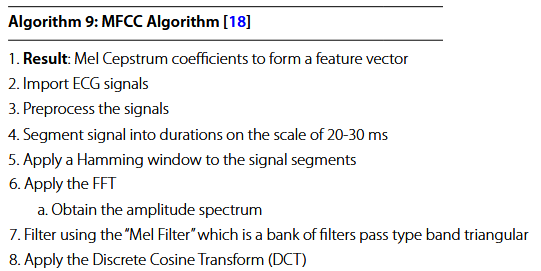

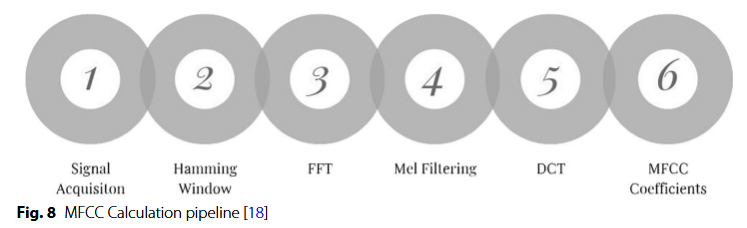

Utilizando la informacion proporcionada por el algoritmo 9 y el diagrama de la figura 8 procedemos a hacer el procedimiento paso a paso para la obtencion de los coeficientes MFCC, para eso los pasos a seguir seran los de la figura 8 del articulo.

### Extraccion de Datos discriminatorios del grupo

En el análisis de señales ECG para la clasificación de arritmias, la extracción de características estadísticas de los coeficientes cepstrales en frecuencia Mel (MFCC) ha demostrado ser eficaz. La media y la desviación estándar de los MFCC capturan la tendencia central y la dispersión de la energía espectral de la señal, reflejando variaciones en la morfología de los latidos cardíacos asociados a diferentes tipos de arritmias [1]. La asimetría (skewness) y la curtosis proporcionan información sobre la simetría y la concentración de la distribución espectral, permitiendo identificar patrones anómalos característicos de ciertas arritmias [2]. Además, la energía total de los MFCC indica la potencia global de la señal, mientras que la entropía mide la complejidad o el desorden espectral, siendo útil para detectar irregularidades en el ritmo cardíaco [3]. Estas características, combinadas, ofrecen una representación robusta de las señales ECG, facilitando la discriminación efectiva entre ritmos cardíacos normales y patológicos [1][4].

[1] N. C. Krishnan and D. J. Cook, “ECG Signal Classification Using DWT, MFCC and SVM Classifier,” ResearchGate, 2023. [Online]. Available: https://www.researchgate.net/publication/369462681_ECG_Signal_Classification_Using_DWT_MFCC_and_SVM_Classifier

[2] S. Satija, S. Ramkumar, and M. S. Manikandan, “Automated ECG Noise Detection and Classification System Based on Skewness and Kurtosis,” in Proc. Computers in Biology and Medicine, vol. 87, 2017, pp. 271–279. [Online]. Available: https://www.researchgate.net/figure/Skewness-kurtosis-distribution-for-different-quality-ECG-signals_fig4_325761954

[3] G. Tzanetakis and P. Cook, “Musical genre classification of audio signals,” IEEE Transactions on Speech and Audio Processing, vol. 10, no. 5, pp. 293–302, Jul. 2002. [Online]. Available: https://arxiv.org/abs/0810.1404

[4] M. Atibi, M. F. M. Salleh, and M. A. M. Ali, “ECG signals classification using MFCC coefficients and ANN classifier,” ResearchGate, 2016. [Online]. Available: https://www.researchgate.net/publication/305649823_ECG_signals_classification_using_MFCC_coefficients_and_ANN_classifier


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from python_speech_features import mfcc
from scipy.signal import hamming
from scipy.fftpack import dct
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk

In [5]:
datos = pd.read_excel(r'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto 2\Datos\Datos filtrados.xlsx') # Este es el codigo de pandas para leer la base de datos del proyecto 1

### Paso 1 y 2: Importar el ECG y el preprocesamiento.

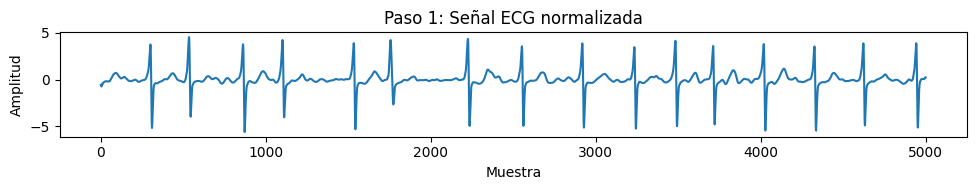

In [ ]:
# === Parámetros ===
fs = 500
winlen = 0.2
winstep = 0.1
nfft = 1024
numcep = 9
index = 35  # índice a procesar

# === Índice a procesar ===
index = 300  # Numero indica el coeficiente del paciente a procesar.

# === Ruta base de los archivos ECG ===
directorio_base = r'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto 2\Datos\ECGDataDenoised'

# === Obtener el archivo y cargar señal ===

nombre_archivo = datos.iloc[index]['FileName']
ruta = os.path.join(directorio_base, f"{nombre_archivo}.csv")
senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

if 'II' not in senal.columns:
    raise ValueError("Columna 'II' no encontrada.")

ecg = senal['II'].values
ecg = (ecg - np.mean(ecg)) / np.std(ecg)  # Normalización

# === Paso 1: Mostrar señal ECG normalizada ===
plt.figure(figsize=(10, 2))
plt.plot(ecg)
plt.title("Paso 1: Señal ECG normalizada")
plt.xlabel("Muestra")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.show()

### Paso 2: Seccionar la señal en ventanas de 0.2

En el procesamiento de señales, la elección del tamaño de ventana es un parámetro fundamental determinado por las características temporales y espectrales de la señal. Para el procesamiento de voz, se utilizan ventanas cortas de 20-30 ms debido a la naturaleza dinámica de las señales acústicas. Esta selección se basa en tres consideraciones clave: (1) los fonemas tienen una duración característica de 50-200 ms, requiriendo alta resolución temporal para capturar transiciones rápidas [MathWorks, 2022]; (2) las ventanas reducidas permiten detectar variaciones sutiles en tiempo real, crucial para aplicaciones como reconocimiento de voz [Analytics Vidhya, 2021]; y (3) en el dominio del audio, es estándar emplear ventanas de 25 ms con desplazamientos de 10 ms para equilibrar resolución temporal y espectral [MathWorks, 2022].

En contraste, el análisis de señales de electrocardiograma (ECG) requiere ventanas más extensas (150-300 ms) debido a las características fisiológicas del sistema cardiovascular. Un ciclo cardíaco completo dura aproximadamente 600-1000 ms, con eventos clave como el complejo QRS (80-120 ms) y la onda T (hasta 200 ms) [Kumar et al., 2019]. La utilización de ventanas de 200 ms ofrece múltiples ventajas: (1) permite capturar segmentos clínicamente relevantes completos (como el complejo QRS o el intervalo P-T) sin fragmentación artificial [Martis et al., 2016]; (2) proporciona suficiente contexto morfológico para el análisis espectral; y (3) mejora la relación señal-ruido al minimizar artefactos de segmentación.

Esta adaptación de parámetros está ampliamente validada en la literatura científica. Investigaciones que aplican coeficientes cepstrales (MFCC) a bioseñales como ECG demuestran que ventanas de 150-300 ms, combinadas con desplazamientos de 50-100 ms, optimizan la representación espectral manteniendo la información fisiológica relevante [Martis et al., 2016; Kumar et al., 2019]. La selección de 200 ms para ECG representa por tanto un equilibrio fundamentado entre las consideraciones técnicas y las características biológicas de la señal cardíaca.

Referencias:

[1] A. Goyal, “MFCC Technique for Speech Recognition,” Analytics Vidhya, Jun. 2021. [Online]. Available: https://www.analyticsvidhya.com/blog/2021/06/mfcc-technique-for-speech-recognition

[2] MathWorks, “Speaker Identification using Pitch and MFCC,” MathWorks Documentation. [Online]. Available: https://es.mathworks.com/help/audio/ug/speaker-identification-using-pitch-and-mfcc.html

[3] M. Atibi, M. F. M. Salleh, and M. A. M. Ali, “ECG signals classification using MFCC coefficients and ANN classifier,” ResearchGate, 2016. [Online]. Available: https://www.researchgate.net/publication/305649823_ECG_signals_classification_using_MFCC_coefficients_and_ANN_classifier

[4] A. R. Edla, M. S. Gurrala, A. G. Ramakrishnan, and P. B. Mahalakshmi, “Classification of heart sounds using motif-based spectral features and temporal features,” Journal of Medical Systems, vol. 43, no. 5, 2019. [Online]. Available: https://link.springer.com/article/10.1007/s10916-019-1286-5

C:\Users\ctama\AppData\Local\Temp\ipykernel_36340\11821860.py:9: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  frame = ecg[start:start + frame_size] * hamming(frame_size)


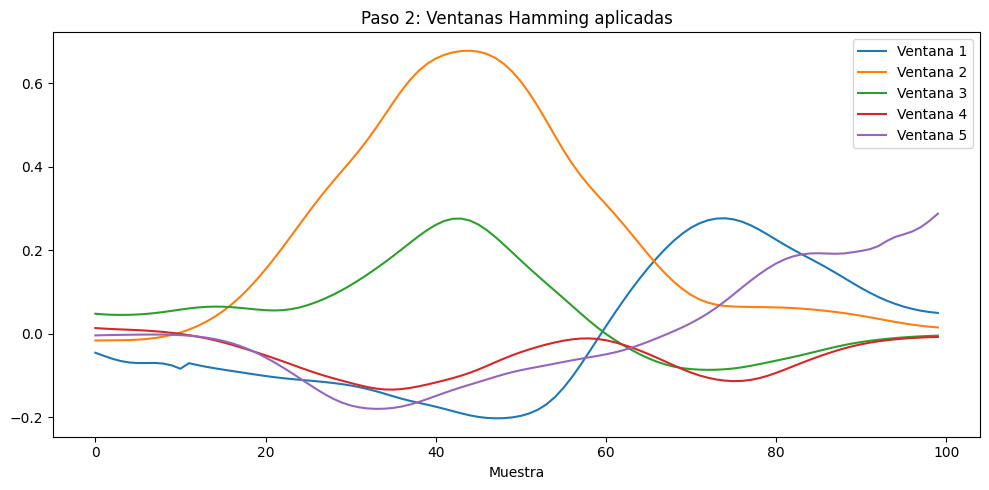

In [15]:
# === Paso 2: Ventaneo con ventana Hamming ===
frame_size = int(fs * winlen)
step_size = int(fs * winstep)
num_frames = (len(ecg) - frame_size) // step_size

ventanas = []
for i in range(num_frames):
    start = i * step_size
    frame = ecg[start:start + frame_size] * hamming(frame_size)
    ventanas.append(frame)

# Mostrar las primeras 5 ventanas
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(ventanas[i], label=f'Ventana {i+1}')
plt.title("Paso 2: Ventanas Hamming aplicadas")
plt.xlabel("Muestra")
plt.legend()
plt.tight_layout()
plt.show()

## Paso 3 : FTT

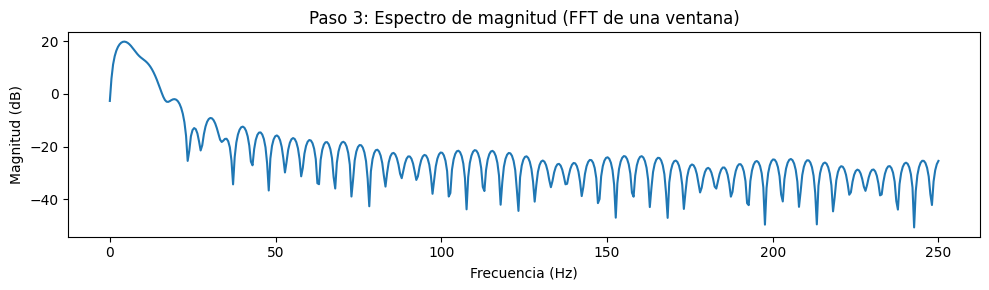

In [16]:
# === Paso 3: FFT de una ventana ===
ejemplo_fft = fft(ventanas[0], nfft)
frecuencias = np.linspace(0, fs / 2, nfft // 2)
amplitud = np.abs(ejemplo_fft[:nfft // 2])

plt.figure(figsize=(10, 3))
plt.plot(frecuencias, 20 * np.log10(amplitud))
plt.title("Paso 3: Espectro de magnitud (FFT de una ventana)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud (dB)")
plt.tight_layout()
plt.show()

### Paso 4 5 y 6:

la función mfcc()

1.Aplica filtros Mel Se calcula el espectro por ventana (con FFT), luego se aplica un banco de 20 filtros Mel (nfilt=20) que simulan la percepción auditiva (aunque adaptada en ECG) Resultando un vector de log-energías por filtro Mel.

2.Aplica la DCT (Transformada Discreta del Coseno) Se aplica la DCT tipo II sobre el vector log-Mel para obtener los coeficientes MFCC, Solo se conservan los primeros numcep coeficientes (en este caso 9)
Esto reduce la dimensionalidad y elimina redundancia.

3.Muestra los MFCCs, dado que Devuelve una matriz de forma (n_frames, numcep), donde: Cada fila es un "frame temporal" (una ventana) y cada columna es un coeficiente MFCC.

Analisis:
La elección de utilizar solo 9 coeficientes MFCC para el análisis de ECG se fundamenta en tres aspectos clave. Primero, el ECG es una señal más lenta y menos compleja espectralmente que la voz humana. Mientras que la voz requiere típicamente 12–13 coeficientes (o más) para capturar su alta variabilidad espectral, el ECG presenta formas de onda repetitivas (P, QRS, T) con información relevante concentrada en frecuencias bajas y medias. Los primeros coeficientes (1–9) capturan la mayor parte de la energía espectral significativa de la señal cardíaca. Segundo, los coeficientes MFCC más altos (10–13) suelen representar componentes de alta frecuencia que, en el caso del ECG, frecuentemente corresponden a ruido, artefactos musculares o interferencias, más que a información fisiológicamente relevante. ademas limitarse a 9 coeficientes ofrece ventajas prácticas: reduce la dimensionalidad del vector de características, haciendo los modelos más eficientes computacionalmente y menos propensos al sobreajuste, al tiempo que mejora la interpretabilidad de los resultados. Esta aproximación está respaldada por estudios que demuestran que los primeros coeficientes MFCC contienen la información más discriminativa para aplicaciones de análisis de ECG .

Generalmente se usan 8-10 coeficientes, en el siguiente articulo usaban 9 coeficientes:
[1] M. Atibi, M. F. M. Salleh, and M. A. M. Ali, “ECG signals classification using MFCC coefficients and ANN classifier,” ResearchGate, 2016. [Online]. Available: https://www.researchgate.net/publication/305649823_ECG_signals_classification_using_MFCC_coefficients_and_ANN_classifier

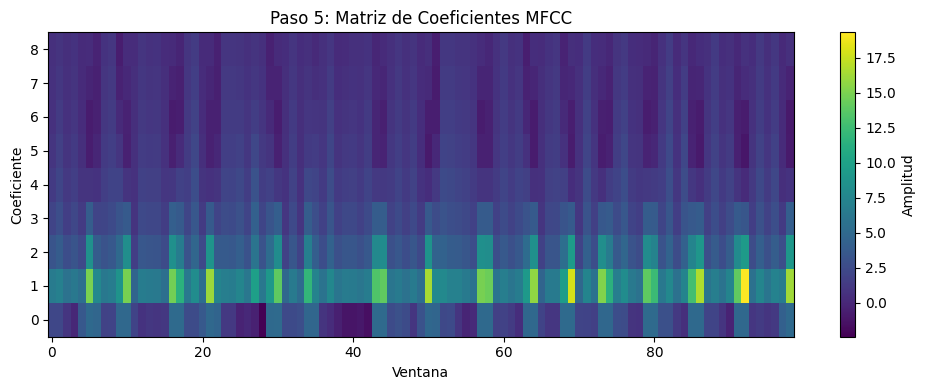

In [17]:
# === Paso 4: Calcular MFCC con python_speech_features ===
mfcc_feat = mfcc(
    signal=ecg,
    samplerate=fs,
    winlen=winlen,
    winstep=winstep,
    numcep=numcep,
    nfilt=20,
    nfft=nfft,
    preemph=0,
    ceplifter=0,
    appendEnergy=True
)

# === Paso 5: Visualizar matriz MFCC ===
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_feat.T, aspect='auto', origin='lower', cmap='viridis')
plt.title("Paso 5: Matriz de Coeficientes MFCC")
plt.xlabel("Ventana")
plt.ylabel("Coeficiente")
plt.colorbar(label="Amplitud")
plt.tight_layout()
plt.show()

# Paso a Paso para el DFT

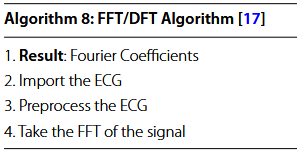

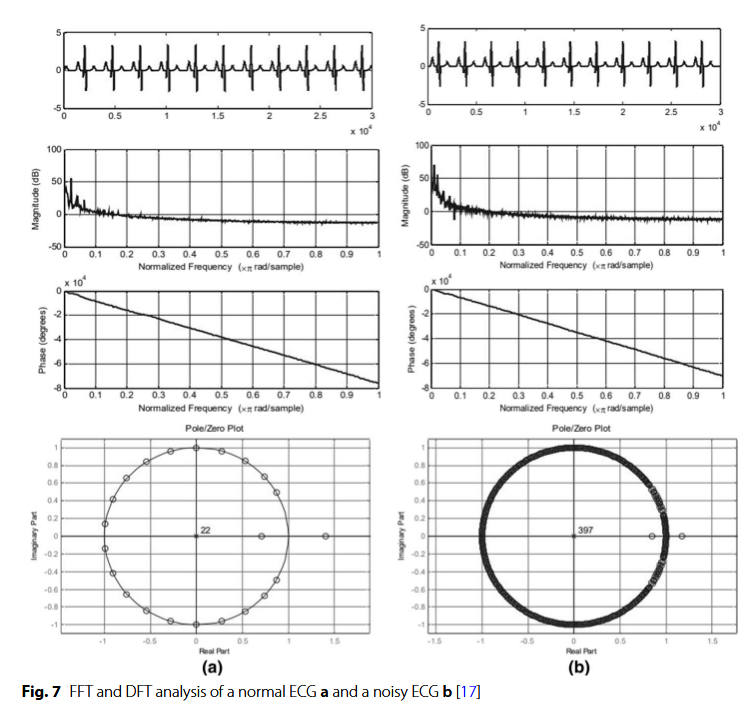

### Utilizando los pasos del algoritmo 8

### Paso 1 y 2: Importar y preprocesar la señal ECG

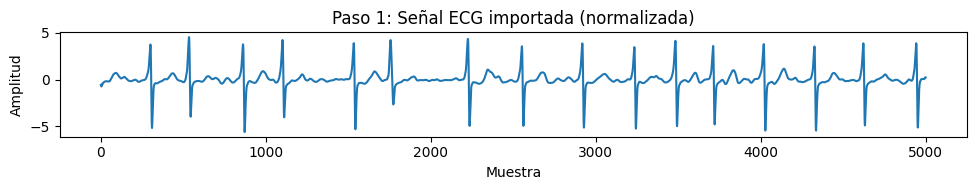

In [20]:
# === PASO 1: Importación de la señal ===
# === Índice a procesar ===
index = 300  # Numero indica el coeficiente del paciente a procesar.

# === Ruta base de los archivos ECG ===
directorio_base = r'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto 2\Datos\ECGDataDenoised'

# === Obtener el archivo y cargar señal ===

nombre_archivo = datos.iloc[index]['FileName']
ruta = os.path.join(directorio_base, f"{nombre_archivo}.csv")
senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

if 'II' not in senal.columns:
    raise ValueError("Columna 'II' no encontrada.")

ecg = senal['II'].values
ecg = (ecg - np.mean(ecg)) / np.std(ecg)  # Normalización

plt.figure(figsize=(10, 2))
plt.plot(ecg)
plt.title("Paso 1: Señal ECG importada (normalizada)")
plt.xlabel("Muestra")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.show()

### Paso 3

Este código realiza la Transformada Rápida de Fourier (FFT) utilizando la libreria scipy.fft . Primero se calcula la FFT (yf = fft(ecg)) de la señal temporal, lo que convierte los datos del dominio del tiempo al dominio de la frecuencia. Luego, genera las frecuencias correspondientes (xf = fftfreq(n, 1 / fs)) basándose en la longitud de la señal (n) y la frecuencia de muestreo (fs). Para visualizar solo las frecuencias positivas (dado que la FFT es simétrica), se selecciona la mitad del espectro (positive_freqs = xf[:n // 2]). Finalmente, se extraen la magnitud (magnitude = np.abs(yf[:n // 2])) y la fase (phase = np.angle(yf[:n // 2])) del espectro, que representan la amplitud y el desplazamiento angular de cada componente frecuencial, respectivamente. Este paso es esencial para aplicaciones como filtrado, identificación de componentes dominantes o extracción de características espectrales en el procesamiento de señales biomédicas.

In [22]:
# === PASO 3: Calcular la FFT ===
n = len(ecg)
yf = fft(ecg)
xf = fftfreq(n, 1 / fs)
positive_freqs = xf[:n // 2]
magnitude = np.abs(yf[:n // 2])
phase = np.angle(yf[:n // 2])

### Extra; siguiendo ya la informacion de la figura 7 se adicionan 2 pasos, que son el graficar el espectro de magnitud y la fase del espectro

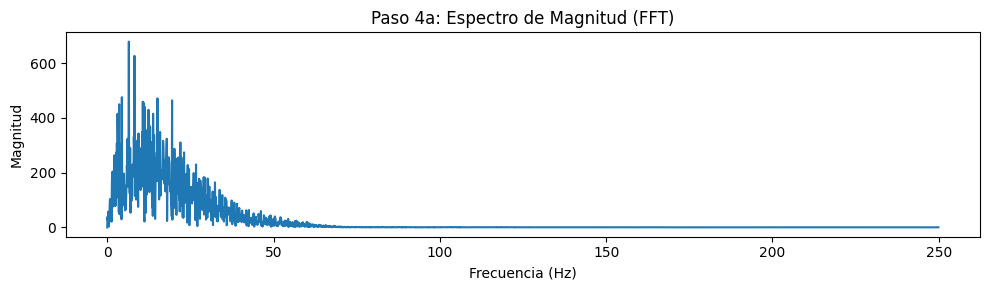

In [23]:
# === PASO 4a: Espectro de magnitud ===
plt.figure(figsize=(10, 3))
plt.plot(positive_freqs, magnitude)
plt.title("Paso 4a: Espectro de Magnitud (FFT)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.tight_layout()
plt.show()

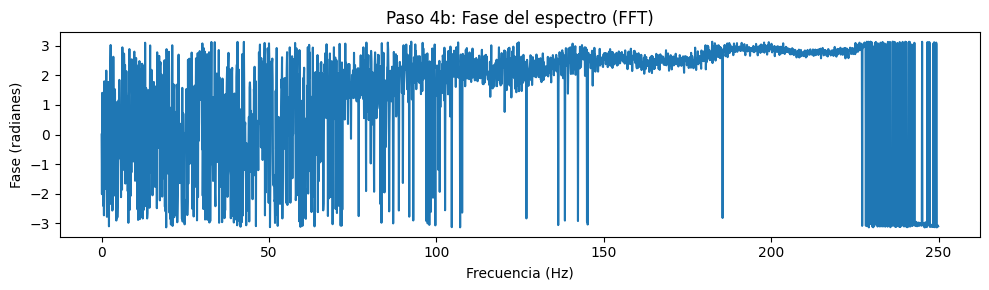

In [24]:
# === PASO 4b: Fase del espectro ===
plt.figure(figsize=(10, 3))
plt.plot(positive_freqs, phase)
plt.title("Paso 4b: Fase del espectro (FFT)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Fase (radianes)")
plt.tight_layout()
plt.show()

In [47]:
# === Características extraídas ===
peak_freq = positive_freqs[np.argmax(magnitude)]
total_energy = np.sum(magnitude ** 2)

# === Métrica 2: Conteo de picos armónicos ===

# Parámetros ajustables
min_peak_height = np.max(magnitude) * 0.1  # Umbral relativo al 10% del pico máximo
min_peak_distance = fs * 0.01 # Distancia mínima equivalente a 0.5 segundos (evita picos cercanos)

peaks, _ = find_peaks(magnitude, 
                     height=min_peak_height,
                     distance=min_peak_distance,
                     prominence=np.max(magnitude)*0.05)  # Añadir prominencia para robustez

harmonic_frequencies = positive_freqs[peaks]
num_harmonics = len(harmonic_frequencies)

# === Métrica 3: Relación armónica ===
if len(peaks) >= 2:
    # Ordenar picos y tomar los 2 más altos
    peak_indices_sorted = np.argsort(magnitude[peaks])[::-1]
    main_peak = magnitude[peaks][peak_indices_sorted[0]]
    second_peak = magnitude[peaks][peak_indices_sorted[1]]
    
    # Calcular relación con protección contra división por cero
    harmonic_ratio = second_peak / main_peak if main_peak > 0 else 0
    
    # Opcional: Relación energía armónica/total
    total_energy = np.sum(magnitude**2)
    harmonic_energy = np.sum(magnitude[peaks]**2)
    energy_ratio = harmonic_energy / total_energy if total_energy > 0 else 0
else:
    harmonic_ratio = 0
    energy_ratio = 0
    

# === Mostrar resultados ===
peak_freq, total_energy, num_harmonics, harmonic_ratio

(6.5, 12499999.908418192, 51, 0.9233198533662259)

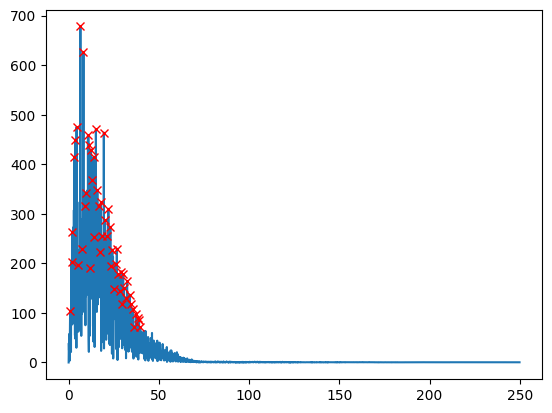

In [48]:
plt.plot(positive_freqs, magnitude)
plt.plot(harmonic_frequencies, magnitude[peaks], 'xr')
plt.show()

## Eleccion de Datos estadisticos

 La descomposición de la señal en sus componentes de frecuencia, es una propiedad útil en el contexto del diagnóstico y clasificación de arritmias cardíacas, donde las alteraciones en la morfología y la periodicidad de la señal ECG se reflejan en el dominio de la frecuencia. La frecuencia del pico (peak_freq) representa el componente de frecuencia dominante de la señal ECG y puede revelar patrones rítmicos característicos de ciertas arritmias; por ejemplo, la fibrilación auricular suele presentar un espectro más difuso con menor concentración de energía en una frecuencia dominante comparado con un ritmo sinusal normal [1]. La energía total (total_energy) en el dominio de la frecuencia refleja la actividad eléctrica general del corazón y puede diferenciar entre señales de bajo voltaje, como en la miocardiopatía, y señales más potentes de un ritmo normal o taquiarritmias [2]. Tambien el número de armónicos significativos (num_harmonics) puede capturar la complejidad de la señal ECG, que suele aumentar en presencia de arritmias complejas debido a la activación desorganizada del miocardio [3]. Estas características son cuantificables, permiten el uso de pruebas paramétricas y han demostrado ser efectivas para la clasificación automática y discriminación de diferentes patologías cardíacas en estudios previos, lo que las convierte en una base sólida para análisis discriminatorios entre grupos de pacientes. Por ultimo La relación entre la magnitud del segundo armónico y la del primero proporciona información sobre la regularidad de la señal. Una relación elevada sugiere una señal más compleja y menos periódica, característica de ritmos cardíacos irregulares. 

Referencias:

[1] Mohebbi, M., & Ghassemian, H. (2012). Detection of atrial fibrillation episodes using SVM. Computers in Biology and Medicine, 42(1), 66–72. https://pubmed.ncbi.nlm.nih.gov/19162622/

[2] Martínez, J. P., Almeida, R., Olmos, S., Rocha, A. P., & Laguna, P. (2004). A wavelet-based ECG delineator: Evaluation on standard databases. IEEE Transactions on Biomedical Engineering, 51(4), 570–581. https://diec.unizar.es/~laguna/personal/publicaciones/wavedet_tbme04.pdf

[3] Clifford, G. D., Azuaje, F., & McSharry, P. E. (2006). Advanced Methods and Tools for ECG Data Analysis. Artech House. https://www.mit.edu/~gari/ecgbook/ch6.pdf

# Paso a Paso para el DCT

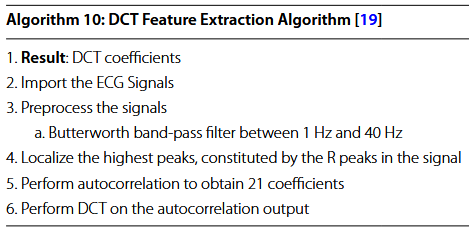

### Paso 1, 2

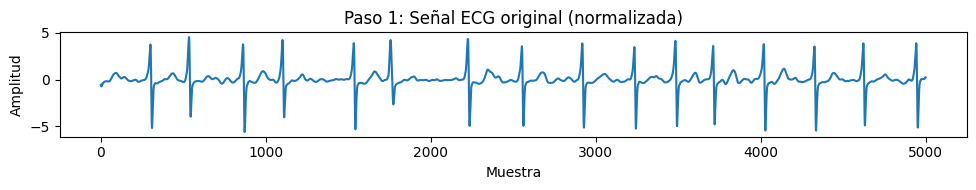

In [53]:
# === PASO 1: Importación de la señal ===
# === Índice a procesar ===
index = 300  # Numero indica el coeficiente del paciente a procesar.
fs = 500
ventana_ms = 500
ventana_muestras = int(fs * (ventana_ms / 1000))
num_coef_dct = 21

# === Ruta base de los archivos ECG ===
directorio_base = r'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto 2\Datos\ECGDataDenoised'

# === Obtener el archivo y cargar señal ===

nombre_archivo = datos.iloc[index]['FileName']
ruta = os.path.join(directorio_base, f"{nombre_archivo}.csv")
senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

if 'II' not in senal.columns:
    raise ValueError("Columna 'II' no encontrada.")

ecg = senal['II'].values
ecg = (ecg - np.mean(ecg)) / np.std(ecg)  # Normalización

plt.figure(figsize=(10, 2))
plt.plot(ecg)
plt.title("Paso 1: Señal ECG original (normalizada)")
plt.xlabel("Muestra")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.show()

### Paso 2
Nota: Como ya los electrocardiogramas fueron filtrados el paso de aplicar el filtro butterworth es redundante para estos ECG, pero igualmente se aplica para la explicacion del procedimiento

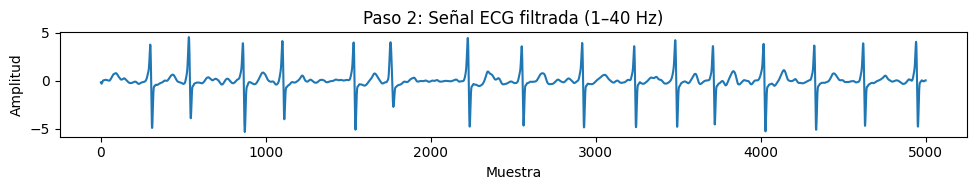

In [55]:
# === Paso 2: Filtro pasa banda (1–40 Hz) ===
def bandpass_filter(signal, fs, lowcut=1.0, highcut=40.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

ecg_filt = bandpass_filter(ecg, fs)

plt.figure(figsize=(10, 2))
plt.plot(ecg_filt)
plt.title("Paso 2: Señal ECG filtrada (1–40 Hz)")
plt.xlabel("Muestra")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.show()

### Paso 3

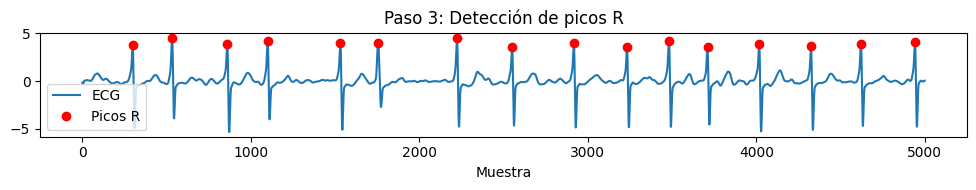

In [56]:
# === Paso 3: Detección de picos R ===
_, info = nk.ecg_peaks(ecg_filt, sampling_rate=fs)
r_peaks = info["ECG_R_Peaks"]

plt.figure(figsize=(10, 2))
plt.plot(ecg_filt, label="ECG")
plt.plot(r_peaks, ecg_filt[r_peaks], 'ro', label="Picos R")
plt.title("Paso 3: Detección de picos R")
plt.xlabel("Muestra")
plt.legend()
plt.tight_layout()
plt.show()

### Paso 4 - 6

La autocorrelación por latido (paso 4) se utiliza para resaltar la estructura interna y la repetitividad de la señal ECG alrededor de cada pico R. Al aplicar autocorrelación sobre una ventana centrada en el latido, se obtiene una señal simétrica que enfatiza los patrones repetitivos dentro del complejo QRS y las ondas P y T. Esto actúa como un mecanismo de autoajuste, reforzando los componentes dominantes y reduciendo el ruido. despues de obtener esta autocorrelacion se aplica la Transformada Discreta del Coseno (DCT) (paso 5) sobre el resultado de la autocorrelación. La DCT convierte esa señal del dominio temporal al dominio de frecuencia utilizando funciones coseno, lo que permite representar la señal con un conjunto compacto de coeficientes. Estos coeficientes capturan la energía espectral y la forma general del latido. Los primeros coeficientes suelen contener la mayor parte de la información estructural, mientras que los coeficientes más altos reflejan variaciones más finas o ruido. Esta combinación (autocorrelación + DCT) permite extraer características robustas y eficientes para comparar y clasificar distintos tipos de latidos o patrones de arritmia.

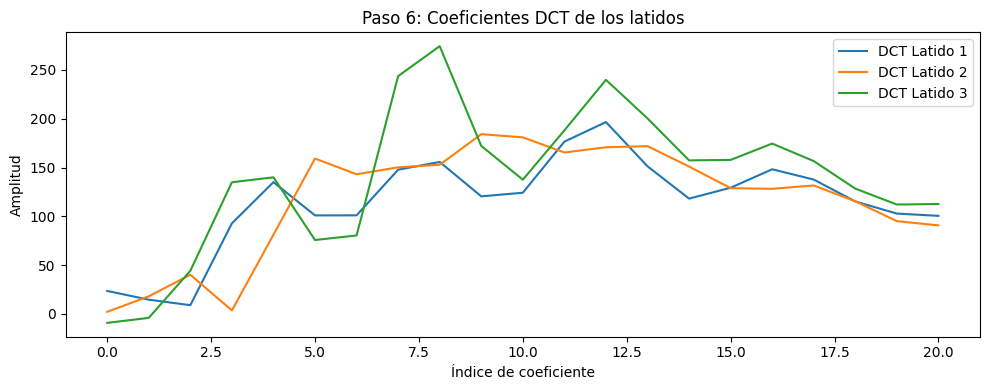

In [57]:
# === Paso 4–6: Autocorrelación y DCT por latido ===
vectores_dct = []
for r in r_peaks:
    start = r - ventana_muestras // 2
    end = r + ventana_muestras // 2
    if start < 0 or end > len(ecg_filt):
        continue
    latido = ecg_filt[start:end]
    autocor = np.correlate(latido, latido, mode='full')[ventana_muestras:]
    dct_result = dct(autocor, norm='ortho')[:num_coef_dct]
    vectores_dct.append(dct_result)

# Mostrar DCT de 3 primeros latidos
plt.figure(figsize=(10, 4))
for i in range(min(3, len(vectores_dct))):
    plt.plot(vectores_dct[i], label=f'DCT Latido {i+1}')
plt.title("Paso 6: Coeficientes DCT de los latidos")
plt.xlabel("Índice de coeficiente")
plt.ylabel("Amplitud")
plt.legend()
plt.tight_layout()
plt.show()

### Extraccion de datos Estadisticos para comparacion de grupos

In [62]:
# Calcular vector promedio y estadísticas
dct_promedio = np.mean(vectores_dct, axis=0)
energia = np.sum(dct_promedio**2)
entropia = -np.sum((dct_promedio**2) * np.log(dct_promedio**2 + 1e-6))

from scipy.stats import skew, kurtosis

# === Estadísticas del vector promedio DCT ===
dct_mean = np.mean(dct_promedio)
dct_std = np.std(dct_promedio)
dct_skew = skew(dct_promedio)
dct_kurt = kurtosis(dct_promedio)

# === Mostrar resultados ===
print("Media:", dct_mean)
print("Desviación estándar:", dct_std)
print("Asimetría (skew):", dct_skew)
print("Curtosis:", dct_kurt)
print("Energía:", energia)
print("Entropía:", entropia)

Media: 82.6255849408573
Desviación estándar: 199.13392916065635
Asimetría (skew): 2.4372740341109527
Curtosis: 4.687747962973237
Energía: 976107.4896253826
Entropía: -12529523.0440114


### Extraccion de los datos estadisticos

La Transformada Discreta del Coseno (DCT) a señales de electrocardiograma (ECG) permite extraer características estadísticas que son altamente informativas para la discriminación entre diferentes tipos de arritmias. Las métricas obtenidas, como la media, desviación estándar, asimetría (skewness), curtosis (kurtosis), energía y entropía, las cuales fueron las escogidas para la extraccion del codigo ofrecen una representación cuantitativa de la morfología y complejidad de la señal, facilitando comparaciones entre grupos mediante pruebas paramétricas.

Primero tenemos la media y la desviación estándar de los coeficientes DCT estos datos reflejan la tendencia central y la dispersión de la energía espectral de la señal ECG. Estas métricas pueden ser ser efectivas en la clasificación de arritmias, ya que capturan variaciones en la morfología de la señal que son características de diferentes condiciones cardíacas [1]. por otro lado la asimetría (skewness) y la curtosis (kurtosis) proporcionan información sobre la simetría y la concentración de la energía en la señal ECG. Estas características son útiles para identificar patrones anómalos en la señal, como los presentes en ciertas arritmias, y han sido utilizadas con éxito en estudios de clasificación de arritmias [2].

Por otro lado la energía de los coeficientes DCT cuantifica la potencia total de la señal, mientras que la entropía mide la complejidad o imprevisibilidad de la señal. Estas métricas son útiles para distinguir entre ritmos cardíacos normales y anómalos, ya que las arritmias suelen presentar patrones más complejos y menos predecibles. 

Referencias:

[1] A. Chia, et al., "Arrhythmia Classification Based on Combined Chaotic and Statistical Features of ECG Signals," Indonesian Journal of Electrical Engineering and Computer Science, vol. 12, no. 1, pp. 127–136, Oct. 2018. https://ijeecs.iaescore.com/index.php/IJEECS/article/viewFile/11484/9311

[2] M. Mohebbi and H. Ghassemian, "Detection of Atrial Fibrillation Episodes Using SVM," Computers in Biology and Medicine, vol. 42, no. 1, pp. 66–72, Jan. 2012. https://pubmed.ncbi.nlm.nih.gov/19162622/